# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [3]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [5]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

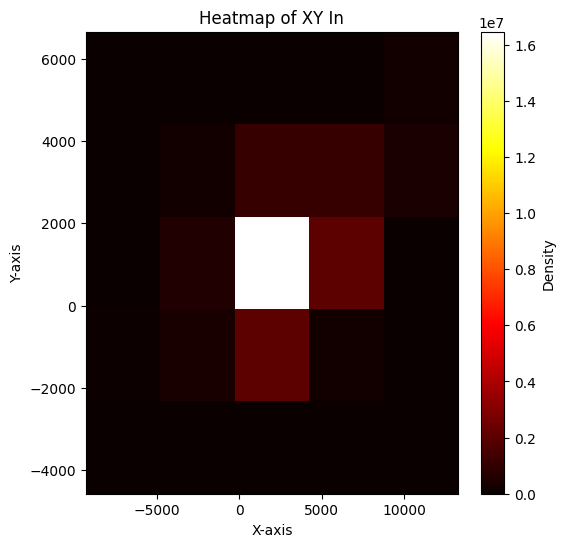

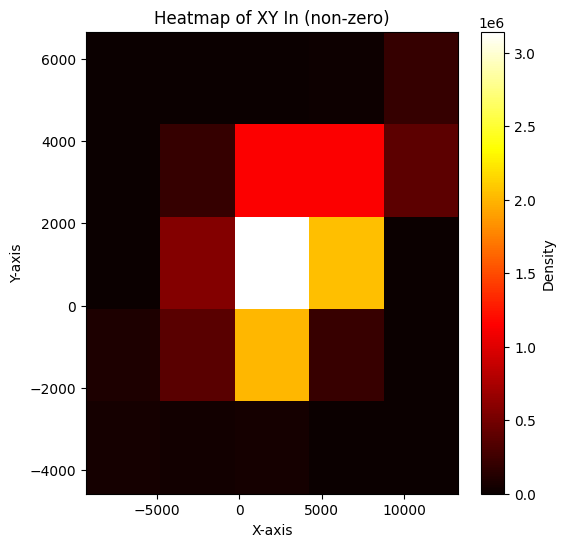

In [6]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

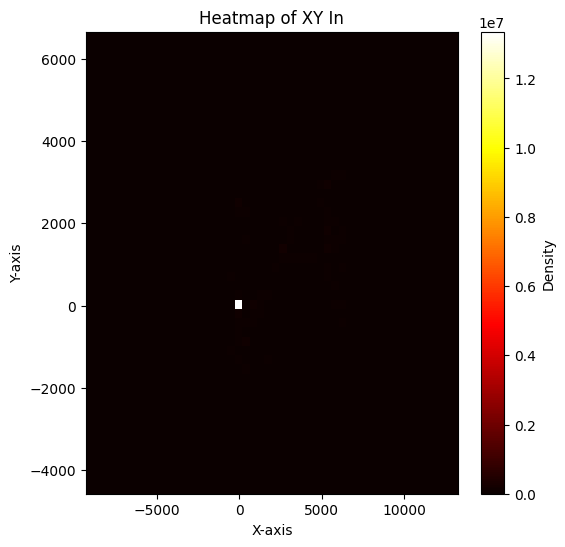

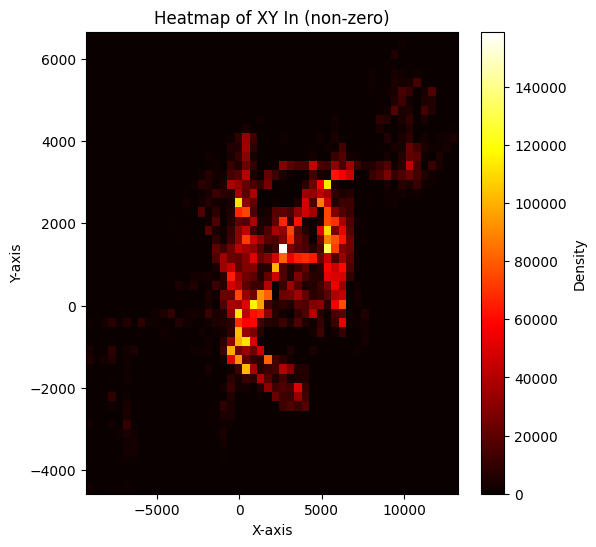

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [8]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [9]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
)

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [10]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [11]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Trying Transformer Model

In [13]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=6, model_dim=128, num_heads=4, num_layers=2, output_dim=60*2, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent index 0, shape: (batch, 50, 6)
        x = self.input_proj(x)  # (batch, 50, model_dim)
        x = self.transformer_encoder(x)  # (batch, 50, model_dim)
        out = self.fc(x[:, -1, :])  # Use last time step's output
        return out.view(-1, 60, 2)

In [14]:
class AdvancedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len
        self.input_proj = nn.Linear(input_dim, model_dim)
        
        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*4,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Decoder for future trajectory
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        x = self.input_proj(x)  # (batch, seq, model_dim)
        x = x + self.pos_encoding[:, :self.seq_len, :]  # Add positional encoding
        x = self.encoder(x)  # (batch, seq, model_dim)
        x = x[:, -1, :]  # Use last time step's output (batch, model_dim)
        out = self.decoder(x)  # (batch, future_len*2)
        return out.view(-1, self.future_len, 2)

In [15]:
class BeefedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # Temporal convolution for local feature extraction
        self.temporal_conv = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=1, groups=input_dim)
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*6,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Deeper MLP decoder with residual connection
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim*2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim*2, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        # Temporal convolution
        x = x.transpose(1, 2)  # (batch, features, seq)
        x = self.temporal_conv(x)
        x = x.transpose(1, 2)  # (batch, seq, features)
        x = self.input_proj(x)
        x = x + self.pos_encoding[:, :self.seq_len, :]
        x = self.encoder(x)
        x = x[:, -1, :]  # Last time step
        out = self.decoder(x)
        return out.view(-1, self.future_len, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [ ]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
# model = TransformerModel().to(device)
# model = AdvancedTransformerModel().to(device)
# model = AdvancedTransformerModel(
#     input_dim=6,
#     model_dim=512,      # 2x wider
#     num_heads=16,       # 2x more heads
#     num_layers=12,      # 2x deeper
#     seq_len=50,
#     future_len=60,
#     dropout=0.10        # Slightly higher dropout for regularization
# ).to(device)

model = BeefedTransformerModel(
    input_dim=6,
    model_dim=1152,
    num_heads=36,
    num_layers=20,
    seq_len=50,
    future_len=60,
    dropout=0.15
).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

C:\Users\Brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [17]:
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step()
    # scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   0%|          | 0/100 [01:05<?, ?epoch/s]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   4.2912 | val normalized MSE   2.6413, | val MAE   6.6464 | val MSE 129.4234


Epoch:   1%|          | 1/100 [02:13<1:51:48, 67.76s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   1.4615 | val normalized MSE   0.8722, | val MAE   3.7901 | val MSE  42.7389


Epoch:   2%|▏         | 2/100 [03:20<1:50:09, 67.45s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.8946 | val normalized MSE   0.7729, | val MAE   3.6013 | val MSE  37.8718


Epoch:   3%|▎         | 3/100 [04:25<1:48:37, 67.19s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.8146 | val normalized MSE   0.7723, | val MAE   3.9876 | val MSE  37.8447


Epoch:   4%|▍         | 4/100 [05:30<1:46:16, 66.43s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.6641 | val normalized MSE   0.5114, | val MAE   2.7886 | val MSE  25.0586


Epoch:   5%|▌         | 5/100 [06:35<1:44:34, 66.05s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.5736 | val normalized MSE   0.4688, | val MAE   2.7247 | val MSE  22.9697


Epoch:   6%|▌         | 6/100 [07:40<1:42:40, 65.54s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.5235 | val normalized MSE   0.4113, | val MAE   2.3808 | val MSE  20.1555


Epoch:   7%|▋         | 7/100 [08:46<1:41:30, 65.49s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.4786 | val normalized MSE   0.3638, | val MAE   2.3610 | val MSE  17.8270


Epoch:   8%|▊         | 8/100 [09:50<1:40:10, 65.33s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.4757 | val normalized MSE   0.3576, | val MAE   2.1768 | val MSE  17.5205


Epoch:  10%|█         | 10/100 [10:55<1:36:59, 64.67s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.4533 | val normalized MSE   0.3985, | val MAE   2.3236 | val MSE  19.5265


Epoch:  10%|█         | 10/100 [11:59<1:36:59, 64.67s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.4607 | val normalized MSE   0.3379, | val MAE   2.1755 | val MSE  16.5562


Epoch:  11%|█         | 11/100 [13:04<1:35:58, 64.71s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.4161 | val normalized MSE   0.3072, | val MAE   2.1595 | val MSE  15.0508


Epoch:  13%|█▎        | 13/100 [14:10<1:33:51, 64.73s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.4629 | val normalized MSE   0.4281, | val MAE   2.4248 | val MSE  20.9776


Epoch:  14%|█▍        | 14/100 [15:14<1:32:18, 64.40s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.4393 | val normalized MSE   0.3360, | val MAE   2.0757 | val MSE  16.4649


Epoch:  15%|█▌        | 15/100 [16:18<1:31:04, 64.29s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.4329 | val normalized MSE   0.4195, | val MAE   2.4767 | val MSE  20.5541


Epoch:  16%|█▌        | 16/100 [17:21<1:29:46, 64.13s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.4231 | val normalized MSE   0.4713, | val MAE   2.8938 | val MSE  23.0943


Epoch:  17%|█▋        | 17/100 [18:25<1:28:31, 63.99s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.4004 | val normalized MSE   0.3263, | val MAE   2.1268 | val MSE  15.9904


Epoch:  18%|█▊        | 18/100 [19:29<1:27:14, 63.84s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.4010 | val normalized MSE   0.3265, | val MAE   2.0558 | val MSE  15.9979


Epoch:  18%|█▊        | 18/100 [20:32<1:27:14, 63.84s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.4006 | val normalized MSE   0.2797, | val MAE   1.9393 | val MSE  13.7044


Epoch:  20%|██        | 20/100 [21:37<1:25:09, 63.87s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.4063 | val normalized MSE   0.3078, | val MAE   2.0888 | val MSE  15.0800


Epoch:  21%|██        | 21/100 [22:40<1:24:03, 63.84s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.3392 | val normalized MSE   0.2865, | val MAE   1.9045 | val MSE  14.0369


Epoch:  21%|██        | 21/100 [23:44<1:24:03, 63.84s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.3293 | val normalized MSE   0.2687, | val MAE   1.7848 | val MSE  13.1667


Epoch:  23%|██▎       | 23/100 [24:49<1:22:07, 63.99s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.3247 | val normalized MSE   0.2884, | val MAE   1.8918 | val MSE  14.1310


Epoch:  23%|██▎       | 23/100 [25:52<1:22:07, 63.99s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.3251 | val normalized MSE   0.2550, | val MAE   1.7229 | val MSE  12.4968


Epoch:  25%|██▌       | 25/100 [26:58<1:20:13, 64.18s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.3217 | val normalized MSE   0.2763, | val MAE   1.8878 | val MSE  13.5403


Epoch:  26%|██▌       | 26/100 [28:02<1:19:02, 64.08s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.3238 | val normalized MSE   0.2568, | val MAE   1.7735 | val MSE  12.5847


Epoch:  27%|██▋       | 27/100 [29:05<1:17:35, 63.77s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.3312 | val normalized MSE   0.2752, | val MAE   1.8388 | val MSE  13.4831


Epoch:  28%|██▊       | 28/100 [30:07<1:15:59, 63.32s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.3156 | val normalized MSE   0.2619, | val MAE   1.7901 | val MSE  12.8338


Epoch:  29%|██▉       | 29/100 [31:08<1:14:05, 62.62s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.3185 | val normalized MSE   0.2804, | val MAE   1.9731 | val MSE  13.7409


Epoch:  30%|███       | 30/100 [32:09<1:12:29, 62.14s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.3203 | val normalized MSE   0.2847, | val MAE   1.8589 | val MSE  13.9491


Epoch:  31%|███       | 31/100 [33:10<1:11:04, 61.80s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.3193 | val normalized MSE   0.2781, | val MAE   2.0440 | val MSE  13.6263


Epoch:  32%|███▏      | 32/100 [34:11<1:09:48, 61.59s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.3188 | val normalized MSE   0.2743, | val MAE   1.9209 | val MSE  13.4416


Epoch:  33%|███▎      | 33/100 [35:12<1:08:33, 61.39s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.3182 | val normalized MSE   0.3088, | val MAE   2.0452 | val MSE  15.1298


Epoch:  33%|███▎      | 33/100 [36:13<1:13:32, 65.86s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.3175 | val normalized MSE   0.2821, | val MAE   2.0914 | val MSE  13.8221
Early stop!


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [18]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

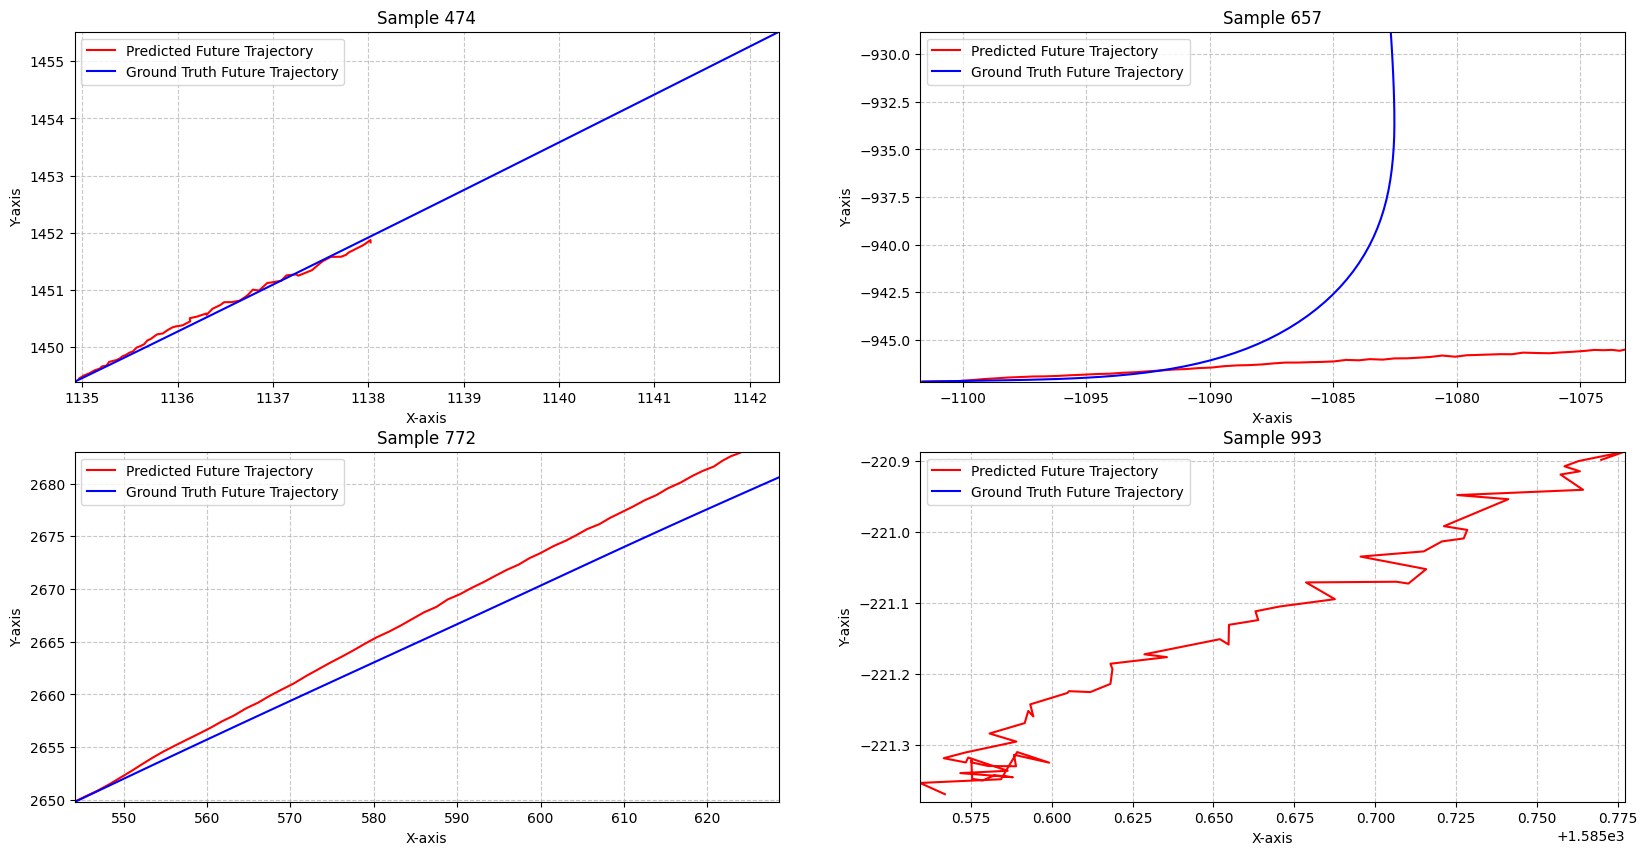

In [19]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [ ]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = AdvancedTransformerModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = BeefedTransformerModel(
    input_dim=6,
    model_dim=1152,
    num_heads=36,
    num_layers=20,
    seq_len=50,
    future_len=60,
    dropout=0.15
).to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B